# Data Science Capstone – the battle of neighborhood – does living in downtown work for everyone?

### Code Demostration

## 1. Import Python Libraries and Dependencies

In [1]:
import numpy as np
import requests
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ------------------------------------------------------------
                       

## 2. Collect and Clean Data

In [2]:
# Scrape raw data from the Wikipedia page using beautifulsoup
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'lxml')
table=soup.find('table')

In [3]:
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
df.head()

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
#Clean "Not assigned" values and combine neighborhoods
df1 = df[df.Borough != 'Not assigned']
df2 = df1.groupby(['Postalcode','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)
df2['Neighborhood'] = np.where(df2['Neighborhood'] == 'Not assigned',df2['Borough'], df2['Neighborhood'])

df2

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
# Extend the dataframe with the latitude and longitude of each borough using csv file
la_lo=pd.read_csv('http://cocl.us/Geospatial_data')
la_lo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [6]:
la_lo.rename(columns={'Postal Code':'Postalcode'},inplace=True)
df_merge = pd.merge(df2,la_lo, on='Postalcode')
df_merge

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [14]:
# Select only the rows with borough "Downtown toronto"
df_toro=df_merge.set_index('Borough', append=True, drop=False).xs('Downtown Toronto', level=1)
df_toro

,Postalcode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
36,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
42,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576


In [17]:
df2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,99
top,M4T,North York,Downsview
freq,1,24,4


In [18]:
from geopy.geocoders import Nominatim
address = 'Downtown,Toronto'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Downtown Toronto are {}, {}.'.format(latitude_x, longitude_y))

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  app.launch_new_instance()


The Geograpical Co-ordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


## 3. Map Downtown Toronto

In [19]:
map_downtown= folium.Map(location=[latitude_x, longitude_y],zoom_start=10)

for lat,lng,borough,neighborhood in zip(df_toro['Latitude'],df_toro['Longitude'],df_toro['Borough'],df_toro['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='green',
    fill=True,
    fill_color='#3155cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_downtown)
map_downtown

##  4. Find the nearby venues

In [20]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: DO0UYTI1TYV2UKB0NCBF0QKUVUAZNOZ00K3SK3OJ4W4WVT4P
CLIENT_SECRET:WPHUHR3SB4VFRFWFRG3YBCEKPLLTR3ZFOEEMZ0LVCB0STKFK


In [22]:
# Get the top 100 venues that are in Downtown Toronto within a radius of 500 meters.
radius = 500 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
from pandas.io.json import json_normalize
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,UNIQLO ユニクロ,Clothing Store,43.655910,-79.380641
1,Elgin And Winter Garden Theatres,Theater,43.653394,-79.378507
2,Ed Mirvish Theatre,Theater,43.655102,-79.379768
3,Indigo,Bookstore,43.653515,-79.380696
4,CF Toronto Eaton Centre,Shopping Mall,43.654540,-79.380677


In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
toronto_venues = getNearbyVenues(names=df_toro['Neighborhood'],
                                   latitudes=df_toro['Latitude'],
                                   longitudes=df_toro['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [29]:
# Top 10 categories
top=pd.Series(nearby_venues.categories)
top.value_counts()[:10]

Coffee Shop                  10
Clothing Store                8
Hotel                         4
Plaza                         3
Restaurant                    3
Middle Eastern Restaurant     3
Diner                         3
Gastropub                     2
Sandwich Place                2
Theater                       2
Name: categories, dtype: int64

##  5. One hot encoding

In [33]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues))
    print('\n')

----Berczy Park----
         venue  freq
0  Coffee Shop  0.08
1         Café  0.03
2       Bakery  0.03
3   Restaurant  0.03
4     Beer Bar  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1   Airport Service  0.12
2  Airport Terminal  0.12
3     Boat or Ferry  0.06
4               Bar  0.06


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.17
1   Italian Restaurant  0.06
2                 Café  0.05
3       Sandwich Place  0.05
4  Japanese Restaurant  0.05


----Christie----
                venue  freq
0       Grocery Store  0.24
1                Café  0.18
2                Park  0.12
3  Italian Restaurant  0.06
4               Diner  0.06


----Church and Wellesley----
                 venue  freq
0          Coffee Shop  0.11
1     Sushi Restaurant  0.05
2  Japanese Restaurant  0.05
3              Gay Bar  0.04
4           Res

In [35]:
def return_most_common_venues(row, top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:top_venues]

In [38]:
top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Beer Bar,Café,Bakery,Cocktail Bar,Cheese Shop,Farmers Market,Seafood Restaurant,Restaurant,Breakfast Spot
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Plane,Coffee Shop,Sculpture Garden,Boat or Ferry,Rental Car Location,Bar,Harbor / Marina
2,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Japanese Restaurant,Burger Joint,Bubble Tea Shop,Bar,Salad Place,Thai Restaurant
3,Christie,Grocery Store,Café,Park,Nightclub,Athletics & Sports,Italian Restaurant,Candy Store,Baby Store,Restaurant,Diner
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Yoga Studio,Mediterranean Restaurant,Hotel,Men's Store,Bubble Tea Shop


## 6. Cluster the neighborhood using KMeans

In [43]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 2, 0, 0, 0, 0, 0, 0], dtype=int32)

In [45]:
neighborhoods_venues_sorted.insert(0, 'Cluster Label', kmeans.labels_)

df_merge =df_toro.iloc[:16,:]

df_merge = df_merge.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_merge.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Yoga Studio,Dessert Shop,Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,0,Coffee Shop,Diner,Yoga Studio,Sushi Restaurant,Park,Creperie,Café,Burrito Place,Mexican Restaurant,Distribution Center
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0,Clothing Store,Coffee Shop,Hotel,Japanese Restaurant,Italian Restaurant,Café,Bubble Tea Shop,Cosmetics Shop,Fast Food Restaurant,Lingerie Store
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0,Coffee Shop,Café,Clothing Store,Cosmetics Shop,Cocktail Bar,Restaurant,American Restaurant,Creperie,Italian Restaurant,Moroccan Restaurant
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,0,Coffee Shop,Beer Bar,Café,Bakery,Cocktail Bar,Cheese Shop,Farmers Market,Seafood Restaurant,Restaurant,Breakfast Spot


## 7. Map the cluster

In [46]:
# create map
map_cluster = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(df_merge['Latitude'], 
                                   df_merge['Longitude'], 
                                   df_merge['Neighborhood'], 
                                   df_merge['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cluster)
       
map_cluster

['#8000ff', '#80ffb4', '#ff0000']


In [47]:
df1=df_merge.loc[df_merge['Cluster Labels'] == 0,df_merge.columns[[2] + list(range(5, df_merge.shape[1]))]]
df2=df_merge.loc[df_merge['Cluster Labels'] == 1,df_merge.columns[[2] + list(range(5, df_merge.shape[1]))]]
df3=df_merge.loc[df_merge['Cluster Labels'] == 2,df_merge.columns[[2] + list(range(5, df_merge.shape[1]))]]

In [55]:
Toronto_Avg_Rent=pd.DataFrame({"Neighborhood":df_toro["Neighborhood"],
                                      "Average_Rent":[2300,2500,2800,2600,3500,3300,2600,1900,2000,2000,4000,3500,3400,
                                                      3400,2600,2300,1400,1800,2800
                                                               ]})

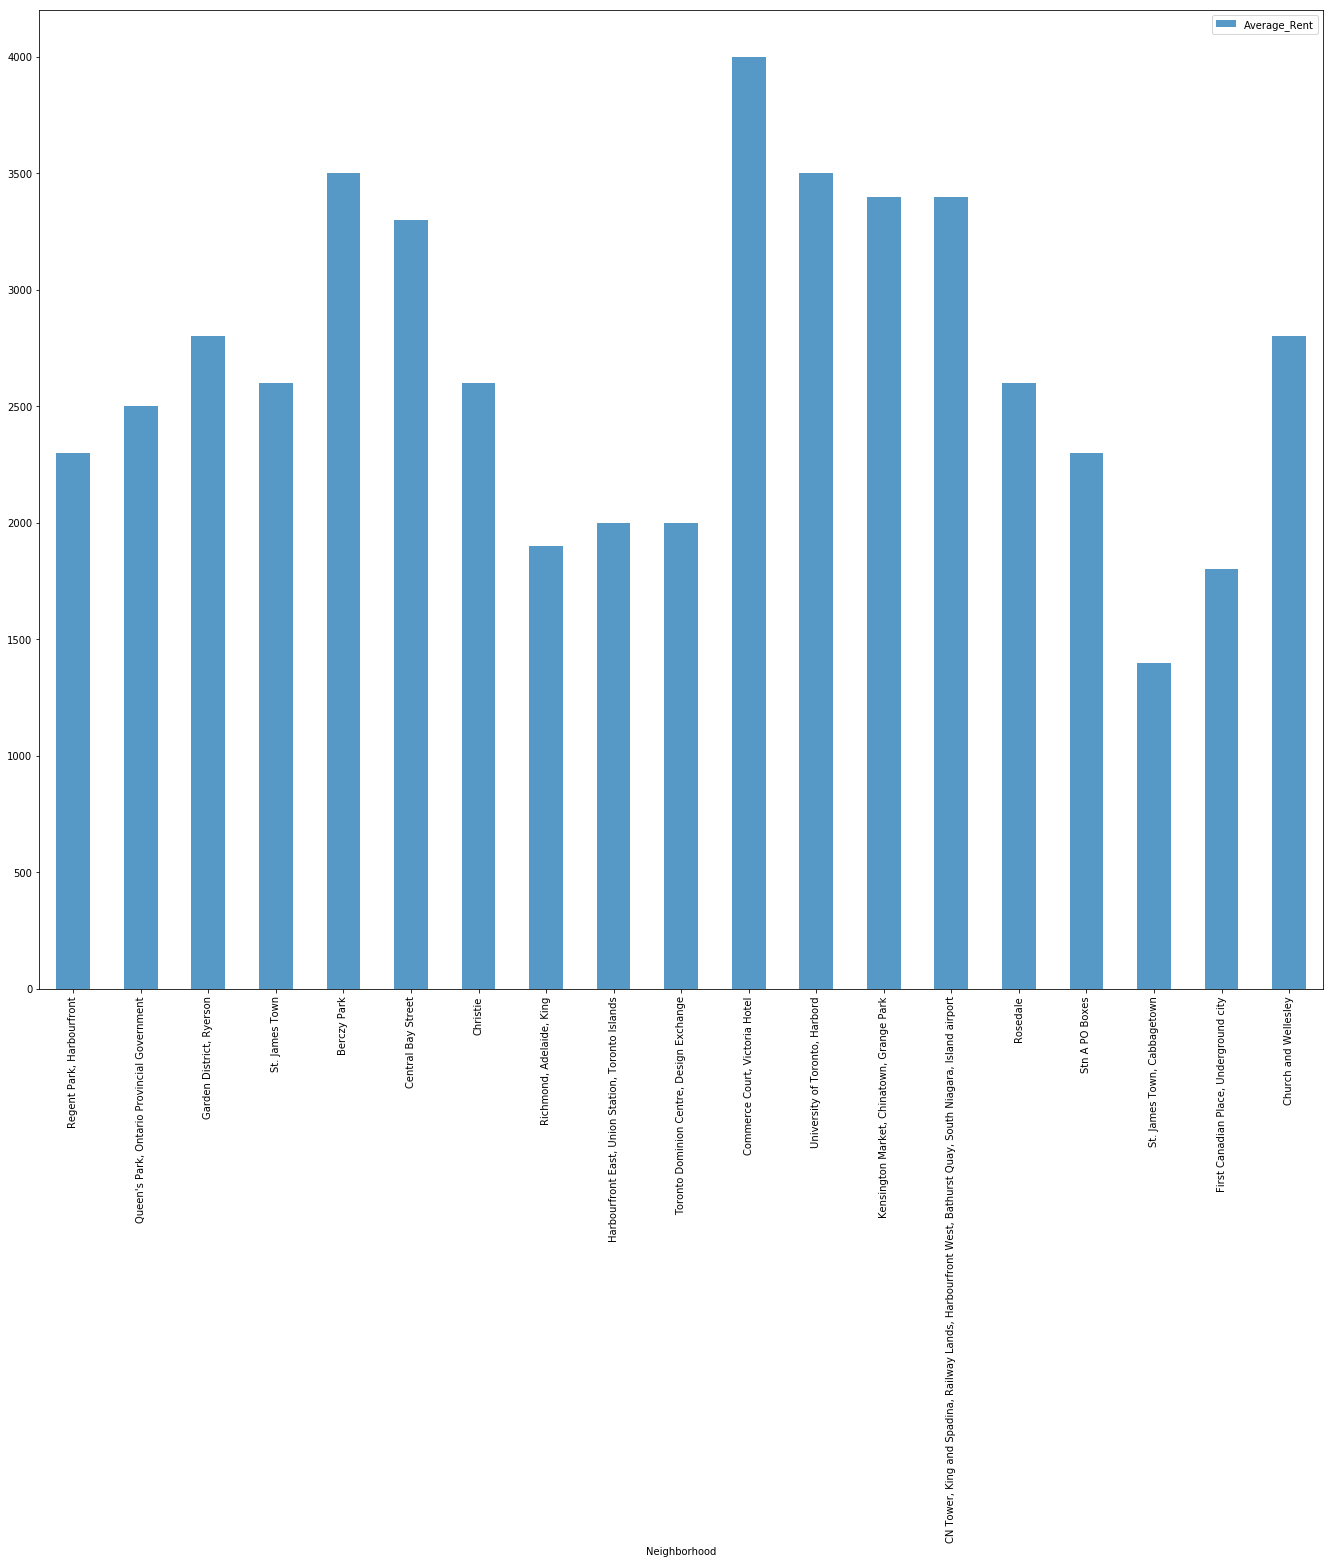

In [56]:
Toronto_Avg_Rent.set_index('Neighborhood',inplace=True,drop=True)
Toronto_Avg_Rent.plot(kind='bar',figsize=(23,18),alpha=0.75)

For complete report, please see Github